---
title: "Decision Tree implementation from scratch with Python"
date: "2025-01-20"
author: Anushka Dhiman
categories: [Machine Learning]
---
___

## What is Decision Tree?

A decision tree is a type of machine learning algorithm used for classification and regression tasks. It consists of a tree-like structure where each internal node represents a feature or attribute, each branch represents a decision based on that feature, and each leaf node represents a predicted output.

To **train** a decision tree, the algorithm uses a dataset with labeled examples to create the tree structure. It starts with the root node, which includes all the examples, and selects the feature that provides the most information gain to split the data into two subsets. It then repeats this process for each subset until it reaches a stopping criterion, such as a maximum tree depth or minimum number of examples in a leaf node.

Once the decision tree is trained, it can be used to **predict** the output for new, unseen examples. To make a prediction, the algorithm starts at the root node and follows the branches based on the values of the input features until it reaches a leaf node. The predicted output for that example is the value associated with the leaf node.

Decision trees have several advantages, such as being easy to interpret and visualize, handling both numerical and categorical data, and handling missing values. However, they can also suffer from overfitting if the tree is too complex or if there is noise or outliers in the data. 

To address this issue, various techniques such as pruning, ensemble methods, and regularization can be used to simplify the decision tree or combine multiple trees to improve generalization performance. Additionally, decision trees may not perform well with highly imbalanced datasets or datasets with many irrelevant features, and they may not be suitable for tasks where the relationships between features and outputs are highly nonlinear or complex.

## Code Implementation

This code is an implementation of a basic Decision Tree Classifier using the Gini impurity for decision tree splitting. 

Let's break it down step by step:

1. The DecisionTree class implements a decision tree classifier. It has methods for fitting the model to the training data and making predictions on new data. It contains max_depth: This parameter limits how deep the tree can grow. If max_depth is set to None, the tree will grow until it can no longer improve the Gini impurity (i.e., when all data points in a node are from the same class).

2. The method fit trains the decision tree using the training data X and the corresponding labels y. It initializes the number of classes (n_classes_) and the number of features (n_features_). It then calls the _grow_tree method to build the decision tree.

3. The predict method makes predictions on a test dataset X. It does this by traversing the decision tree for each data point.

4. The _gini_ method calculates the Gini impurity of a set of labels \( y \). It is used to measure how "impure" a node is. If all the labels in a node are the same, the Gini impurity is zero (pure node). The formula for Gini impurity is:

$$ Gini(y) = 1 - \sum \left( \frac{\text{count}(y_i)}{n} \right)^2 $$

Where:

- \( \text{count}(y_i) \) is the frequency of class \( y_i \) in the node.

- \( n \) is the total number of data points in that node.

5. The _best_split method finds the best feature and threshold to split the data at each node. It calculates the Gini impurity for each possible split and selects the one that minimizes the Gini impurity.

Here’s how it works:

For each feature:

- Sort the data by the feature values.

- For each possible threshold (based on the values of the feature), divide the data into two groups: left and right of the threshold.

- Calculate the Gini impurity of both groups (left and right) and find the best threshold that minimizes the combined Gini impurity.

The function returns:

- best_idx: the feature index that provides the best split.

- best_thr: the threshold value that minimizes the Gini impurity

6. The _grow_tree method builds the decision tree recursively. It splits the data at each node and creates child nodes until one of the following stopping criteria is met:

- The depth of the tree reaches max_depth.

- The node contains data that cannot be split further (all data points belong to the same class).

At each node:

- The majority class is determined and used as the predicted class for that node.

- The tree is recursively split using the best feature and threshold.

7. The _predict method takes a data point and traverses the decision tree until it reaches a leaf node. It then returns the predicted class of that leaf node.

In [1]:
import numpy as np

class DecisionTree:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        
    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))  # Number of unique classes
        self.n_features_ = X.shape[1]  # Number of features
        self.tree_ = self._grow_tree(X, y)  # Build the tree
        
    def predict(self, X):
        return [self._predict(inputs) for inputs in X]
        
    def _gini(self, y):
        _, counts = np.unique(y, return_counts=True)
        impurity = 1 - np.sum([(count / len(y)) ** 2 for count in counts])
        return impurity
        
    def _best_split(self, X, y):
        m = y.size
        if m <= 1:
            return None, None
        
        num_parent = [np.sum(y == c) for c in range(self.n_classes_)]
        best_gini = 1.0 - sum((n / m) ** 2 for n in num_parent)
        best_idx, best_thr = None, None
        
        for idx in range(self.n_features_):
            thresholds, classes = zip(*sorted(zip(X[:, idx], y)))
            num_left = [0] * self.n_classes_
            num_right = num_parent.copy()
            for i in range(1, m):
                c = classes[i - 1]
                num_left[c] += 1
                num_right[c] -= 1
                gini_left = 1.0 - sum(
                    (num_left[x] / i) ** 2 for x in range(self.n_classes_)
                )
                gini_right = 1.0 - sum(
                    (num_right[x] / (m - i)) ** 2 for x in range(self.n_classes_)
                )
                gini = (i * gini_left + (m - i) * gini_right) / m
                if thresholds[i] == thresholds[i - 1]:
                    continue
                if gini < best_gini:
                    best_gini = gini
                    best_idx = idx
                    best_thr = (thresholds[i] + thresholds[i - 1]) / 2
        
        return best_idx, best_thr
        
    def _grow_tree(self, X, y, depth=0):
        num_samples_per_class = [np.sum(y == i) for i in range(self.n_classes_)]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)
        if depth < self.max_depth:
            idx, thr = self._best_split(X, y)
            if idx is not None:
                indices_left = X[:, idx] < thr
                X_left, y_left = X[indices_left], y[indices_left]
                X_right, y_right = X[~indices_left], y[~indices_left]
                node.feature_index = idx
                node.threshold = thr
                node.left = self._grow_tree(X_left, y_left, depth + 1)
                node.right = self._grow_tree(X_right, y_right, depth + 1)
        return node
        
    def _predict(self, inputs):
        node = self.tree_
        while node.left:
            if inputs[node.feature_index] < node.threshold:
                node = node.left
            else:
                node = node.right
        return node.predicted_class
    
class Node:
    def __init__(self, *, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0.0 
        self.left = None
        self.right = None

    def is_leaf_node(self):
        return self.left is None and self.right is None


Let's run an example with a simple dataset and visualize the decision tree. We'll use the Iris dataset, which is commonly used for classification tasks, and visualize how the decision tree splits the data based on features.

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Load the Iris dataset
iris = load_iris()
X = iris.data[:, :2]  # Only using the first two features (sepal length, sepal width)
y = iris.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Decision Tree classifier
tree = DecisionTree(max_depth=3)
tree.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.78


## Visualization

We visualize the decision boundaries of the decision tree based on the first two features of the Iris dataset (sepal length and sepal width).

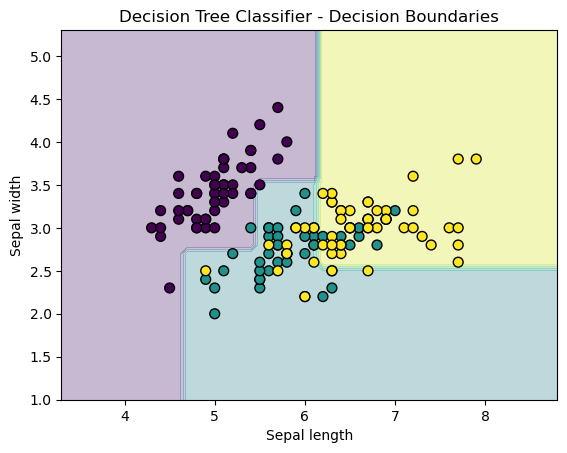

In [4]:
# Visualization of the decision boundaries
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

Z = np.array([tree._predict([x, y]) for x, y in zip(xx.ravel(), yy.ravel())])
Z = Z.reshape(xx.shape)


plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, edgecolor='k')
plt.title("Decision Tree Classifier - Decision Boundaries")
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()


In the above example,

- We create a mesh grid to cover the entire feature space (sepal length and sepal width).
- For each point on the grid, we predict its class using the trained decision tree and plot the decision boundaries.
- Data points are also plotted on top of the decision boundary with different colors representing different classes.